# Práctica 2: Aprendizaje y selección de modelos de clasificación\*

### Minería de Datos: Curso académico 2020-2021

### Profesorado:

* Juan Carlos Alfaro Jiménez
* José Antonio Gámez Martín

### Alumnos:

* Sara López Matilla
* Carlos Morote García

\* Adaptado de las prácticas de Jacinto Arias Martínez y Enrique González Rodrigo

## Introducción

En esta libreta se han estudiado y analizado los modelos más utilizados en `scikit-learn`. Se ha buscado el mejor modelo con sus respectivos hiperparámetros, con el objeto de obtener el mejor clasificador posible para los conjuntos de datos de `pima-indians-diabetes` y `breast-cancer-wisconsin-data`.

* Carga de datos
* Modelos de clasificación supervisada
* Evaluación de modelos
* Selección de modelos
* Construcción y validación del modelo final

Se analizará haciendo una replicación parcial del Kernel: [Logistic Regression & Data Preprocessing por faressayah](https://www.kaggle.com/faressayah/logistic-regression-data-preprocessing)

Sin embargo, antes hay que realizar una preparación del entorno.


## Preparación del entorno

Antes de entrar en materia con los datos es necesario disponer de las herramientas oportunas para hacerlo. Esto es lo que se puede encontrar en este apartado, siendo la parte más fundamental la de importar todos los paquetes de Python que se van a usar.

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# Third party
from sklearn.base import clone
from sklearn.model_selection import train_test_split

# Preprocessing
from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Normalizer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Validation
from sklearn.model_selection import RepeatedStratifiedKFold

# Scripts
import miner_a_de_datos_aprendizaje_modelos_utilidad as utils

Con el objeto de que los experimentos sean reproducibles se ha establecido una semilla para la generación de números aleatorios. La semilla ha sido generada de forma aleatoria también. Se ha obtenido haciendo uso de la página: [random.org](http://random.org)

In [ ]:
seed = 337839890

## Pima Indians Diabetes Database

En esta sección se va a analizar el conjunto de datos `pima_diabetes`. Como ya vimos en la práctica anterior, está compuesto por ocho variables predictoras y una objetivo.

Las variables predictoras son:
* `Pregnancies`: número de veces que ha estado embarazada.
* `Glucose`: concentración de la glucosa en dos horas en un test de tolerancia oral a la glucosa.
* `BloodPressure`: presión arterial diastólica (mmHg).
* `SkinThickness`: grosor del pliegue de la piel del tríceps (mm).
* `Insulin`: insulina sérica en dos horas ($\mu$U/ml).
* `BMI`: índice de masa corporal (peso(kg)/(altura(m))^2).
* `DiabetesPedigreeFunction`: función de pedigrí de la diabetes. Esta función analiza las relaciones genealógicas de un ser vivo en el contexto de determinar cómo una cierta característica o fenotipo se hereda y manifiesta, en este caso, la diabetes.
* `Age`: edad de la paciente.

La variable objetivo es Outcome. Tiene dos posibles valores: 0 significa que no se tiene diabetes y 1 significa que sí se tiene diabetes.

### Carga de datos

Primero se va a cargar el conjunto de datos. Se debe poner el parámetro `index` a `None` debido a que esta base de datos no tiene una columna índice.

In [ ]:
filepath = "../input/pima-indians-diabetes-database/diabetes.csv"

index = None
target = "Outcome"

data = utils.load_data(filepath, index, target)

Vamos a visualizar una muestra del conjunto de datos, concretamente, cinco instancias aleatorias.

In [ ]:
data.sample(5, random_state=seed)

Primero procedemos a partir el conjunto de datos en conjunto de datos de entrenamiento y conjunto de datos de test. Estos dos subconjuntos que se obtienen se subdividen a su vez en `X`, siendo las variables predictoras, y en `y`, siendo la variable objetivo. Se ha optado por dividir el conjunto de datos en un 70% para el conjunto de entrenamiento y un 30% para el conjunto de test.

Debido a que en ocasiones se utilizará el conjunto de entrenamiento y de test sin distinguir entre variables predictoras y objetivo, y en otras ocasiones se distinguirá, se van a obtener los conjuntos dividos y sin dividir.

In [ ]:
train_size = 0.7

(train, tests, X_train, X_test, y_train, y_test) = utils.split_data(data, target, seed, train_size)

Vamos a comprobar que se ha realizado satisfactoriamente la partición del conjunto de datos en entrenamiento y test.

In [ ]:
X_train.sample(5, random_state=seed)

In [ ]:
y_train.sample(5, random_state=seed)

In [ ]:
print(f"Numeros de instancias train: {train.shape[0]}")
print(f"Numeros de variables train: {train.shape[1]}")
train.sample(5, random_state=seed)

In [ ]:
print(f"Numeros de instancias test: {tests.shape[0]}")
print(f"Numeros de variables test: {tests.shape[1]}")
tests.sample(5, random_state=seed)

## Modelos de clasificación supervisada

### Preprocesamiento

Se va a usar el preprocesamiento que se realizó en la práctica anterior para realizar el pipeline, aunque se van a realizar modificaciones que se irán indicando.

#### Selección de variables

Se van a usar todas las variables, excepto SkinThickness y Insulin, como ya hicimos en la práctica anterior. Como ya se comentó, esta selección de variables se va a realizar en el make_column_selector al imputar los valores perdidos implícitamente.

---

#### Eliminación de outliers

Para realizar la eliminación de *outliers* se va a usar el mismo método que usamos en la práctica anterior, que se realizaba mediante un `IsolationForest`.

In [ ]:
remove_outliers = FunctionSampler(func=utils.outlier_rejection, kw_args={"random_state":seed})

---

#### Imputación de valores perdidos

Como se vio en la práctica anterior, hay que imputar los valores perdidos de las variables `Glucose`, `BloodPresure` y `BMI`. Todas estas variables se van a imputar por la media, a diferencia de la práctica anterior, en la que las variables con valores enteros se imputaron por la moda.

Volvemos a resaltar que en este paso se realiza la eliminación de variables.

In [ ]:
numerical_imputing = make_pipeline(SimpleImputer(strategy="mean", missing_values=0))


num = 'BMI|Glucose|BloodPressure'
non = 'Pregnancies|DiabetesPedigreeFunction|Age'

impute_missing = make_column_transformer(
(numerical_imputing, make_column_selector(pattern=num)),
('passthrough', make_column_selector(pattern=non)))

---

#### Discretización

En este caso, vamos a variar los discretizadores para ver qué configuración nos permite alcanzar mejores resultados. Sin embargo, eso lo haremos en el grid, así que ahora crearemos solo el discretizador que se usó en la práctica anterior.

Solo vamos a modificar el hiperparámetro `n_bins`. En esta ocasión, se va a juntar la discretización con la codificación, debido a que no hay problemas con la representación del árbol de decisión, que fue lo que hizo que se usara por separado la discretización y la codificación en la práctica anterior. La estrategia será siempre `kmeans` debido a que en la práctica anterior observamos que no había una partición clara por igual anchura o igual frecuencia que permitiese una buena discretización.

In [ ]:
discretizer = KBinsDiscretizer(n_bins=4, encode="onehot", strategy="kmeans")

---

#### Normalización

Para esta práctica, va a ser necesario normalizar los datos en algunos algoritmos, como es el caso del algoritmo de los vecinos más cercanos. Para ello, vamos a crear un método que nos permite normalizar los datos.

In [ ]:
normalize = Normalizer()

## Modelos

Primeros vamos a crear los diferentes pipelines que se van a necesitar para evaluar cada algoritmo. A todos los modelos se les va a eliminar los *outlayers* y se les va a imputar los valores perdidos.

Es necesario tener en cuenta que estos pipelines se van a crear solo para la evaluación de modelos mediante una validación cruzada, la optimización de hiperparámetros y su explicación de por qué se usan o no se hará en la sección de selección de modelos.

### Vecinos más cercanos

Este algoritmo necesita que las variables numéricas estén normalizadas en la misma escala, para ello le vamos a aplicar el normalizador. Este algoritmo no necesita un discretizador.

Para crear este algoritmo, el único parámetro que vamos a incluir es el número de vecinos y cómo se evalua el voto de cada vecino. En optimización de parámetros se modificarán más parámetros.

In [ ]:
n_neighbors = 5
weights = 'distance'

k_neighbors_model = make_pipeline(
        remove_outliers,
        impute_missing,
        normalize,
        KNeighborsClassifier(n_neighbors,
                             weights=weights)
)

---

### Árboles de decisión

Como ya se hizo en la práctica anterior, se le va a aplicar un discretizador como preprocesamiento adicional.

Los hiperparámetros que se van a introducir en este ejemplo de árbol de decisión son la máxima profundidad, que se va a fijar a 5, al no parecer una profundidad demasiado pequeña ni grande, se va a usar el critero de la entropía, se va a aplicar una post-poda con un alfa de 0.1 y se va a restringir el árbol para que cada hoja tenga como mínimo 20 ejemplos.

In [ ]:
decision_tree_model = make_pipeline(
        remove_outliers,
        impute_missing,
        discretizer,
        DecisionTreeClassifier(random_state=seed,
                               max_depth=5,
                               criterion='entropy',
                               ccp_alpha=0.1,
                               min_samples_leaf=20)
)

---

### Adaboost

Adaboost es una versión del ensemble Boosting. Se asignan pesos a las instancias y se aprenden de forma secuencial una serie de árboles débiles y con mucho sesgo. Si un ejemplo es clasificado bien en una iteración, en la siguiente iteración su peso será menor. Si es clasificado mal en una iteración, en la siguiente iteración tendrá mayor peso. La agregación de resultados se realiza por un voto ponderado por la importancia del clasificador.

En este caso no se va a aplicar ningún preprocesamiento adicional, debido a que la documentación de `scikit-learn` recomienda no discretizar, debido a que se obtienen mejores resultados, así que seguiremos esta recomendación.

El único hiperparámetro que vamos a modificar de este ensemble en esta ocasión va a ser la profundidad máxima, debido a que para este ensemble se requieren modelos débiles. Por ello, se va a realizar un *Uno-R*.

In [ ]:
adaboost_model = make_pipeline(
        remove_outliers,
        impute_missing,
        AdaBoostClassifier(random_state=seed,
                           base_estimator=DecisionTreeClassifier(max_depth=1))
)

---

### Bagging

Este ensemble aprende un modelo en cada iteración. La particularidad de este algoritmo está en que en cada iteración usa un subconjunto de las instancias de entrenamiento. La elección de este subconjunto se realiza mediante muestreo aleatorio con reemplazo. La agregación de resultados se realiza mediante un voto por la mayoría. Este modelo reduce la varianza al computar los votos.

A este ensemble se le va a pasar el discretizador como preprocesamiento adicional.

El estimador que se va a usar para este hiperparámetro va a ser un árbol de decisión de máxima profundidad, debido a que este modelo usa árboles muy profundos y muy ramificados.

In [ ]:
bagging_model = make_pipeline(
        remove_outliers,
        impute_missing,
        discretizer,
        BaggingClassifier(random_state=seed,
                          base_estimator=DecisionTreeClassifier(max_depth=None))
)

---

### Random Forest

Este ensemble es una combinación de modelos con forma de árbol. Cada árbol se contruye de forma independiente de forma aleatoria mediante una selección de las instancias y las características que componen el árbol. No se lleva a cabo poda, pero se puede limitar el tamaño. Este ensemble reduce la varianza en el modelo base y más aún por la agregación.

Como a todos los modelos basados en árboles que hemos visto hasta ahora, se le aplicará un discretizador como paso adiccional en el preprocesamiento.

En este caso, vamos a utilizar el árbol por defecto que construye `scikit-learn` si no modificamos sus hiperparámetros.

In [ ]:
random_forest_model = make_pipeline(
        remove_outliers,
        impute_missing,
        discretizer,
        RandomForestClassifier(random_state=seed)
)

---

### Gradient Boosting

Este ensemble mezcla la técnica de Boosting con el gradiente descendiente. En cada iteración se usan los residuos que se han obtenido mediante el gradiente descendiente en la iteración anterior. En cada iteración se usan todos los modelos aprendidos anteriormente.

A este ensemble se le va a aplicar el discretizador en el preprocesamiento.

Para construir este modelo inicial, vamos a dejar el árbol que construye `scikit-learn` por defecto.

In [ ]:
gradient_boosting_model = make_pipeline(
        remove_outliers,
        impute_missing,
        discretizer,
        GradientBoostingClassifier(random_state=seed)
)

---

### Histogram Gradient Boosting


Este ensemble es una versión de Gradient Boosting. Construye un histograma, es decir, agrupa los valores en diferentes rangos, y considera esos rangos para la construcción del árbol. Es mucho más rápido que la versión estándar, sobre todo con un conjunto de datos significativo.

En este caso no se va a aplicar discretización, ya que al agrupar los valores por rangos se está haciendo una discretización.

Al igual que en Gradient Boosting, se va a utilizar el árbol por defecto.

In [ ]:
hist_gradient_boosting_model = make_pipeline(
        remove_outliers,
        impute_missing,
        HistGradientBoostingClassifier(random_state=seed)
)

## Evaluación de modelos

Para evaluar todos los modelos que hemos construido, vamos a realizar una validación cruzada. En este caso será una validación cruzada de diez carpetas con cinco repeticiones. Es importante remarcar que será una validación cruzada estratificada. Primero creamos esta validación cruzada.

In [ ]:
n_splits = 10
n_repeats = 5

cv = RepeatedStratifiedKFold(n_splits=n_splits,
                             n_repeats=n_repeats,
                             random_state=seed)

Antes de empezar a evaluar nuestros modelos vamos a  explicar las métricas que se van a usar. Al igual que en la práctica anterior nos centramos en el recall en esta se buscará lo mismo. Para ello se han propuesto dos métricas, como son ` balanced_accuracy` y ` recall_weighted`. 

` balanced_accuracy` es una métrica usada en problemas binarios de clasificación cuando las clases están desbalanceadas. Esta métrica esta basada en otras dos métricas: la *sensibilidad* o el *recall* (ratio de verdaderos positivos) y *especificidad* siendo el ratio de verdaderos negativos. 
 
`recall_weighted` es una métrica idéntica al recall sin embargo el peso de cada valor dependerá del soporte que tenga. Para variables con mayor soporte tendrán menor peso y viceversa. 

Puesto que queremos centrarnos en obtener el mejor clasificador posible, tanto para detectar casos positivos como negativos evaluaremos nuestro modelo en base a la métrica `balanced_accuracy`.

In [ ]:
scoring = ['balanced_accuracy', 'recall_weighted']

### Vecinos más cercanos

In [ ]:
utils.evaluate_estimator(k_neighbors_model, X_train, y_train, cv, scoring)

En este modelo podemos observar una gran varianza entre el resultado obtendio con el conjunto de entrenamiento y el conjunto de test, tanto para el `balanced_accuracy` como para el `recall_weighted`. En el conjunto de entrenamiento obtiene puntuaciones muy altas, de aproximadamente algo menos de un 95% para ambas métricas, mientras que el conjunto de test no alcanza ni siquiera un 70% en ambas métricas.

---

### Árbol de decisión

In [ ]:
utils.evaluate_estimator(decision_tree_model, X_train, y_train, cv, scoring)

Podemos observar que este modelo obtiene una puntuación más baja que el modelo de los vecinos más cercanos, sin embargo, no se obtiene tanta diferencia entre los resultados del entrenamiento y los del test, lo cual es un buen dato. Sin embargo, este resultado no es demasiado vinculante, debido a que los hiperparámetros que hemos usado para la construcción del modelo pueden no ser los óptimos.

---

### Adaboost

In [ ]:
utils.evaluate_estimator(adaboost_model, X_train, y_train, cv, scoring)

Se puede observar que este modelo obtiene mejores resultados que los dos modelos anteriores, sin embargo, podemos observar que la varianza entre los resultados obtenidos en el entrenamiento y los obtenidos en el test es bastante alta.

---

### Bagging

In [ ]:
utils.evaluate_estimator(bagging_model, X_train, y_train, cv, scoring)

Se puede ver que obtenemos unos resultados peores que con Boosting y con los vecinos más cercanos. Se debe remarcar una gran variación entre los resultados obtenidos con el conjunto de entrenamiento y los obtenidos con el conjunto de test.

---

### Random Forest

In [ ]:
utils.evaluate_estimator(random_forest_model, X_train, y_train, cv, scoring)

Este ensemble obtiene peores resultados que Boosting y unos resultados parecidos al algoritmo de los vecinos más cercanos. Volvemos a observar la gran variación entre los resultados obtenidos con el conjunto de entrenamiento y el conjunto de test.

---

### Gradient Boosting

In [ ]:
utils.evaluate_estimator(gradient_boosting_model, X_train, y_train, cv, scoring)

Este ensemble obtiene un resultado peor que Boosting, sin embargo, obtiene un `recall_weigthed` muy parecido. Se vuelve a observar la gran diferencia entre los resultados de entrenamiento y los resultados de test.

---

### Histogram Grading Boosting

In [ ]:
utils.evaluate_estimator(hist_gradient_boosting_model, X_train, y_train, cv, scoring)

Este modelo obtiene unos resultados muy parecidos a Boosting, de hecho, se obtienen resultados mejores en las milésimas, sin embargo, no es un márgen lo suficientemente amplio para poder decir que se han obtenido unos resultados mejores.

Con esta evaluación de modelos mediante una validación cruzada hemos obtenido que los mejores modelos son Boosting e Histogram Gradient Boosting. Si hacemos caso solamente a los resultados numéricos que hemos obtenido, diremos que el mejor modelo es Histogram Gradient Boosting. No obstante, si tenemos en cuenta el principio de la navaja de Ockam, por el cual si tenemos dos modelos iguales debemos escoger el menos complejo, podemos decir que el mejor modelo es Boosting.

Sin embargo, estas conclusiones no tienen una gran validez, ya que no hemos usado los hiperparámetros óptimos para cada modelo. Por ello, en la siguiente sección vamos a seleccionar los mejores hiperparámetros para cada modelo.

## Selección de modelos

Vamos a empezar a buscar en un grid la mejor configuración de parámetros para cada algoritmo. Se va a usar la métrica `balanced_accuracy` para escoger los parámetros óptimos. No obstante, también se va a mostrar el `recall_weighted` para poder comparar.

### Vecinos más cercanos

De este algoritmo se va a elegir tres parámetros para optimizar:

* `n_neighbors`: el resultado que se va a obtener dependerá mucho del número de vecinos más cercanos que se elijan, debido a que si el número de vecinos es demasiado bajo, el algoritmo tenderá a sobreajustar y tendrá mucha varianza, pero si es demasiado alto, el resultado será muy parecido al `Zero-R`, porque clasificará por la clase mayoritaria. Se van a elegir números impares de vecinos para no encontrar el caso de empate en los resultados, desde el 1 al 13.
* `weights`: este hiperparámetro indica si la clasificación se realiza por el voto por la mayoría (`uniform`) o por el voto pesado por la inversa de la distancia (`distance`). El valor que tome puede influir en la configuración encontrada.
* `p`: este hiperparámetro nos indica si la métrica que se elige para calcular la distancia entre vecinos es la distancia de Manhattan (p=1) o si es la distancia euclídea (p=2).

In [ ]:
estimator = k_neighbors_model

n_neighbors = [1, 3, 5, 7, 9, 11, 13]
weights = ["uniform", "distance"]
p = [1,2]


k_neighbors_clf = utils.optimize_params(estimator,
                                        X_train, y_train, cv,
                                        kneighborsclassifier__n_neighbors=n_neighbors,
                                        kneighborsclassifier__weights=weights,
                                        kneighborsclassifier__p=p,
                                        scoring=scoring, refit='balanced_accuracy')

Los mejores parámetros que se obtienen son con 11 vecinos, usando la distancia de Manhattan y el voto mediante la mayoría.
 
Si miramos las cinco mejores configuraciones, podemos observar que tienen entre 9 y 13 vecinos y todos utilizan la distancia de Manhattan. Sin embargo, no parece hay homogeneidad en cuanto a qué estrategia de voto es mejor.

El número óptimo de vecinos que se ha encontrado es un valor moderado, debido a que no es un valor demasiado próximo a 1 ni demasiado alto, teniendo en cuenta que se suele calcular el número de vecinos entre 1 y $\sqrt{N}$, siendo este valor 23 en este conjunto de entrenamiento. Este número nos proporciona robustez contra el ruido, es decir, reduce la varianza que este algoritmo puede tener con una cantidad baja de vecinos.

Podemos observar que si cogemos la métrica `recall_weighted`, los resultados son bastante similares, solo encontramos algunas permutaciones.

---
### Árbol de decisión

Para este modelo vamos a evaluar los siguientes hiperparámetros:
* `criterion`: se va a probar qué criterio es mejor, si la entropía o gini.
* `max-depth`: indica la máxima profundidad que alcanza el árbol. Un árbol demasiado ramificado tenderá a sobreajustar, y por tanto a tener mucha varianza, mientras que un árbol con demasiadas pocas ramas tenderá a subajustar, y por tanto, tener mucho sesgo. Sin embargo, un árbol con la profundidad adecuada tenderá a generalizar correctamente y así se evitará el sobreajuste y el subajuste. Se van a usar los valores 3, 5, 7 y sin profundidad máxima.
* `min_samples_split`: el mínimo número de ejemplos que debe tener un nodo interno para generar otra rama. Puede ayudar a combatir el sobreajuste, ya que no permite hojas con muy poco ejemplos en ellas. Vamos a usar los valores 2 (para evitar tener hojas con un solo ejemplo), 10, 20 y 30.
* `ccp_alpha`: este hiperparámetro se usa para la post-poda, lo cual también ayuda a evitar el sobreajuste.

Además, también se van a modificar los hiperparámetros del discretizador que se le pasa mediante el pipeline, concretamente, se va a modificar el número de bins.

In [ ]:
estimator = decision_tree_model

criterion = ['entropy', 'gini']
max_depth = [3, 5, 7, None]
min_samples_split = [2, 10, 20, 30]
ccp_alpha = [0.0, 0.05, 0.1]

n_bins = [2, 4, 6]

decision_tree_clf = utils.optimize_params(estimator,
                                        X_train, y_train, cv,
                                        decisiontreeclassifier__criterion=criterion,
                                        decisiontreeclassifier__max_depth=max_depth,
                                        decisiontreeclassifier__min_samples_split=min_samples_split,
                                        decisiontreeclassifier__ccp_alpha=ccp_alpha,
                                        kbinsdiscretizer__n_bins = n_bins,
                                        scoring=scoring, refit='balanced_accuracy')

Primero vamos a analizar la mejor configuración mirando la tabla. Podemos observar que en esta ocasión se ha obtenido un empate en las mejor configuración. Todas estas configuraciones tienen en común que discretizan en dos intervalos. Esto es normal, debido a que el árbol de decisión hace particiones binarias para cada rama que crea. En cuanto al resto de parámetros, no se observa un gran consenso. Parece que el mejor criterio es la entropía. Parece que es positivo realizar una post-poda. Sin embargo, no parece claro cuál es la mejor profundidad máxima para el árbol, debido a que encontramos árboles de todas las profundidades posibles. Esto se puede deber a que no es necesaria tanta profundidad, ya que se obtiene el mismo resultado con una menor profundidad. Podemos observar mediante la poda que se tiende a reducir la varianza.

En el mejor resultado que nos ofrece el método podemos observar que tiene una máxima profundidad de 3, que es la mínima que podía tener, una poda de 0.05, un mínimo de dos hojas para generar otra rama, que es el número mínimo y el criterio de la entropía. Si comparamos esto con las conclusiones generales que hemos obtenido, podemos remarcar que este método ha elegido el modelo más simple para desempatar, siguiendo el principio de la navaja de Ockam.

En cuanto al ranking obtenido con el recall_weigthed, podemos observar que también parece haber empates. En la última posición de este ranking podemos observar los mismos hiperparámetros que en el caso de balanced_accuracy. Sin embargo, los que hemos obtenido como mejores, están en la posición 97.

---
### Adaboost

En este caso solo nos interesa modificar un hiperparámetro:
* `learning_rate`: reduce la contribución de cada clasificador. Se va a probar si un es mejor un valor alto, un valor medio o un valor alto.

En los árboles que se van a aprender en este ensemble, se van a modificar los siguientes hiperparámetros:
* `max_depth`: como se quieren obtener modelos débiles y con mucho sesgo, se va a optar por controlar la máxima profundidad que pueden alcanzar. Se va a optar por profundidades de 1, 2 y 3.
* `criterion`: se va a volver a buscar si es mejor el criterio de la entropía o el criterio gini.

In [ ]:
estimator = adaboost_model

learning_rate = [0.3, 0.5, 1]

max_depth = [1, 2, 3]
criterion = ['entropy', 'gini']

adaboost_clf = utils.optimize_params(estimator,
                                        X_train, y_train, cv,
                                        adaboostclassifier__learning_rate=learning_rate,
                                        adaboostclassifier__base_estimator__max_depth=max_depth,
                                        adaboostclassifier__base_estimator__criterion=criterion,
                                        scoring=scoring, refit='balanced_accuracy')

---
### Bagging

Para este ensemble se van a modificar dos hiperparámetros:
* `max_samples`: se va a observar si es mejor elegir un conjunto mayor o menor de ejemplos. Se optará por mirar el 25%, 50%, 75% y 100%.
* `oob_score`: se va a observar la diferencia entre usar el error *Out of Bag* o no usarlo.
Se podría modificar también el número máximo de atributos que se pueden escoger, pero no se va a implementar debido a que el algoritmo que vimos en la clase de teoría no lo hacía.

Del árbol de decisión solo se va a comprobar un hiperparámetro, que va a ser `criterion`.

También se va a comprobar la discretización.

In [ ]:
estimator = bagging_model

max_samples = [0.25, 0.5, 0.75, 1]
oob_score = [True, False]

criterion = ['entropy', 'gini']

n_bins = [2, 4, 6]

bagging_clf = utils.optimize_params(estimator,
                                     X_train, y_train, cv,
                                     baggingclassifier__max_samples=max_samples,
                                     baggingclassifier__oob_score=oob_score,
                                     baggingclassifier__base_estimator__criterion=criterion,
                                     kbinsdiscretizer__n_bins = n_bins,
                                     scoring=scoring, refit='balanced_accuracy')

Si observamos la tabla, podemos notar que obtenemos los mismos resultados con el error *Out of Bag* que sin él, por tanto, podemos concluir que este hiperparámetro no influye en el resultado. La elección entre el criterio de entropía y el criterio gini no parece influir demasiado, debido a que no podemos observar una clara mejoría de uno contra el otro. En cuanto al número de intervalos, parece mejor la configuración de 4 o 6 intervalos. Relativo al número de ejemplos máximos que podemos elegir, parece que elegir el 100% de los ejemplos no es una buena elección, ya que tendría más opciones de instancias para escoger, y se asemejaría más al algoritmo de un árbol de decisión tradicional. Además, sería más probable los árboles que construye el ensemble estén relacionados entre sí al haber mayor probabilidad de escoger los mismos ejemplos. Podemos observar que reduce la varianza.

Si comparamos los dos rankings que obtenemos con las dos métricas, podemos observar que los peores resultados están clasificados en las partes inferiores de la tabla en ambos rankings. Sin embargo, las primeras posiciones varían de un ranking a otro.

---

### Random Forest

Los hiperparámetros que vamos a modificar en este algoritmos son:
* `criterion`: como en todos los demás árboles, vamos a comprobar si es mejor el criterio de la entropía o el criterio gini.
* `max_depth`: en este ensemble, al construir árboles bastante más profundos de lo que haría un `C4.5`, se puede limitar su profundidad. Por tanto, probaremos con una máxima profundidad que sea bastante profunda, para no limitar demasiado su crecimiento. Se probará con 5, 7, 9 y sin máxima profundidad.
* `max_features`: se mirará el número máximo de atributos que se van a evaluar para construir el mejor árbol. Se va a probar con el 50%, el 75% y el 100%. 
* `max_samples`: el máximo número de instancias que van usar también es un hiperparámetro importante para no obtener árboles muy dependientes. Se va a mirar el 25% y el 50%, debido a que en Bagging hemos observado que es mejor que este porcentaje no sea muy alto, y ambos modelos están relacionados.
En este caso no se va a probar con el conjunto *Out of Bag*, debido a que antes hemos obtenido en Bagging que era indiferente usar este conjunto o no.

De nuevo, se va a probar la configuración del discretizador.

In [ ]:
estimator = random_forest_model

criterion = ['entropy', 'gini']
max_depth = [5, 7, 9, None]
max_features = [0.5, 0.75, 1]
max_samples = [0.25, 0.5]

n_bins = [2, 4, 6]

random_forest_clf = utils.optimize_params(estimator,
                                               X_train, y_train, cv,
                                               randomforestclassifier__criterion=criterion,
                                               randomforestclassifier__max_depth=max_depth,
                                               randomforestclassifier__max_features=max_features,
                                               randomforestclassifier__max_samples=max_samples,
                                               kbinsdiscretizer__n_bins=n_bins,
                                               scoring=scoring, refit='balanced_accuracy')

Observando los cinco mejores resultados de la tabla, podemos observar algo curioso, y es que aunque el que obtiene mejor puntuación usa el criterio gini, los otros cuatro usan el criterio de la entropía, por tanto, no podemos obtener conclusiones sólidas sobre qué criterio es mejor. Se puede observar que el número óptimo de bins en el que realizar la discretización es 6. En cuanto a la máxima profundidad que deben tener los árboles, se obtienen mejores resultados con árboles más profundos, incluso sin limitar su profundidad. En cuanto el máximo número de atributos, podemos observar que los mejores resultados son el 50% y el 75%, siendo el 100% el que peores resultado obtiene. El mejor número de ejemplos, como ya intuíamos, está entre el 25% y el 50%. Los resultados del máximo número de atributos e instancias se deben a que con estos rangos obtenemos árboles menos relacionados entre sí, que es lo que hace que los ensembles obtengan mejores resultados. Todo esto reduce la varianza, y además la agregación hace que se reduzca aún más la varianza.

Como en la mayoría de los demás modelos, al comparar las dos métricas, observamos que los resultados que se encuentran al final de la tabla son los mismos, mientras que los resultados que se encuentran al principio varían.

---

### Gradient Boosting

Para este ensemble vamos a considerar los siguientes hiperparámetros:
* `loss`: se va a evaluar si se consiguen mejores resultados con la regresión logística (`deviance`) o con el algoritmo AdaBoost (`exponential`). 
* `learning_rate`: la tasa de aprendizaje se va calcular entre 0.05 y 0.1.
* `subsample`: si esta métrica es menor que 1, se usa el Gradient Boosting estocástico. Vamos a probar si es mejor el ensemble normal o el estocástico. Se usará 0.5, 0.75 y 1.
* `max_depth`: su valor por defecto es 3, por tanto, probaremos con 2, 3 y 4.

Como anteriormente, se optimizará el parámetro de la discretización.

In [ ]:
estimator = gradient_boosting_model

loss = ['deviance', 'exponential']
learning_rate = [0.05, 0.1]
subsample = [0.5, 0.75, 1]
max_depth = [2, 3, 4]

n_bins = [2, 4, 6]

gradient_boosting_clf = utils.optimize_params(estimator,
                                               X_train, y_train, cv,
                                               gradientboostingclassifier__loss = loss,
                                               gradientboostingclassifier__learning_rate = learning_rate,
                                               gradientboostingclassifier__subsample = subsample,
                                               gradientboostingclassifier__max_depth=max_depth,
                                               kbinsdiscretizer__n_bins=n_bins,
                                               scoring=scoring, refit='balanced_accuracy')

Si nos fijamos en las cinco primeras configuraciones, parece que la función de pérdida del algoritmo Adaboost funciona mejor que la logística, debido a que para la misma configuración de los demás hiperparámetros, obtenemos mejores resultados con la exponencial. En cuanto a la tasa de aprendizaje, para mejor la tasa de 0.1. Parece que funciona mejor la versión estocástica, lo cual es razonable, debido a que esta versión es una mejora respecto a la versión normal. Si observamos el criterio de la máxima profundidad, no es posible sacar ninguna conclusión precisa, debido a que todas las profundidades que hemos seleccionado están recogidas. Podemos observar que al tener poca profundidad, estos árboles tienen sesgo, lo cual se reduce mediante el ensemble. Respecto al número de intervalos en los que realizamos la discretización, parece claro que el mejor número es 6, y que 2 es el peor.

Si comparamos las dos métricas, observamos que los resultados varían.

---

### Histogram Gradient Boosting

Los hiperparámetros que se van a optimizar son diferentes a los que hemos usado en el Gradient Boosting, debido a que no todos los hiperparámetros presentes en dicho algoritmo no están implementados en Histogram Gradient Boosting. Se van a optimizar los siguientes:
* `learning_rate`: vamos a observar si es mejor una tasa de aprendizaje más alta o más baja.
* `max_depth`: vamos a modificar la máxima profundidad para observar cómo influye en los resultados.

En un principio se había pensado en cambiar la función de pérdida, pero solo exiten dos funciones implementadas:  `binary_crossentropy`, que es la pérdida logística, y `categorical_crossentropy`, que es para variables multiclase. Como en este conjunto de datos solo tenemos una clase binaria, no podemos modificar estos valores.

Es importante remarcar que no se va a realizar la discretización en el preprocesamiento, debido a que este ensemble realiza una discretización interna.

In [ ]:
estimator = hist_gradient_boosting_model

learning_rate = [0.025, 0.05, 0.075, 0.1]
max_depth = [1, 2, 3, 4, 5]

hist_gradient_boosting_clf = utils.optimize_params(estimator,
                                               X_train, y_train, cv,
                                               histgradientboostingclassifier__learning_rate = learning_rate,
                                               histgradientboostingclassifier__max_depth=max_depth,
                                               scoring=scoring, refit='balanced_accuracy')

Podemos observar que la peor tasa de aprendizaje es 0.025, mientras que la mejor tasa no puede especificarse muy bien, debido a que en los mejores resultados obtenemos las otras tres tasas. En relación a la máxima profundidad, podemos observar que los mejores números son 2, 3 y 4, es decir, se obtienen modelos individuales con sesgo, que se soluciona mediante la agregación de los resultados.

En cuanto a la comparación de las dos tasas de rendimiento, podemos observar que la posición del ranking varía mucho según se usa una u otra.

## Construcción del modelo final

Finalmente, vamos a comprobar qué modelo es mejor. Para ello vamos a comprobar su rendimiento repecto al conjunto de test.

In [ ]:
estimators = {
    "Nearest neighbors": k_neighbors_clf,
    "Decision tree": decision_tree_clf,
    "AdaBoost": adaboost_clf,
    "Bagging": bagging_clf,
    "Random Forests": random_forest_clf,
    "Gradient Boosting": gradient_boosting_clf,
    "Histogram Gradient Boosting": hist_gradient_boosting_clf
}

In [ ]:
utils.evaluate_estimators(estimators, X_train, y_train, X_test, y_test)

Como hemos utilizado el `balanced_accuracy` durante la selección de parámetros para escoger el mejor modelo, debemos escoger también esta métrica para elegir el modelo final. En esta tabla está representada en la columna *score*. Podemos observar que el modelo que mayor puntuación obtiene en esta métrica es Gradient Boosting, aunque Adaboost le sigue con un resultado muy parecido, solo diferenciado por cinco milésimas. Como se puede observar, hemos obtenido unos resultados diferentes a los que habíamos obtenido mediante la validación cruzada. Esto se debe a que hemos usado los mejores parámetros para cada modelo, y no unos arbitrarios.

Como en el caso de la validación cruzada, debemos plantearnos si la mejora de Gradient Boosting frente a Adaboost es suficiente teniendo en cuenta la complejidad que Gradient Boosting introduce y si cinco milésimas se considera una diferencia lo suficientemente alta para considerarla mejor. Como ya hicimos en el caso de la validación cruzada, vamos a tener en cuenta el principio de la navaja de Ockam y vamos a escoger el modelo más sencillo. Por tanto, podemos concluir que el mejor modelo es Adaboost.

El modelo que peor resultado ha obtenido ha sido el algoritmo de los vecinos más cercanos, con casi una décima menos de puntuación respecto al mejor modelo. El siguiente peor modelo ha sido Bagging, siendo superado incluso por el árbol de decisión. Esto no suele ser lo normal. Este hecho se puede deber a que los parámetros no se han optimizado todo lo bien que deberían o que por un casual al ajustar la semilla hemos hallado una combinación que llevaba a este resultado. El siguiente ha sido el árbol de decisión, seguido con muy poca diferencia por el Histogram Gradient Boosting. El tercer mejor modelo ha sido Random Forest.

Como última reflexión, podemos observar que Histogram Gradient Boosting es peor que su versión estándar, a pesar de que debería ser mejor. Esto se puede deber a varios factores. El primero de ellos se puede deber a que no hemos usado los mismos parámetros en ambos modelos, debido a que no estaban implementados en la versión del histograma. El segundo factor se puede deber a que la versión de histograma es mejor cuando el tamaño de la base de datos es muy grande, con una base de datos pequeña, como puede ser este caso, no se ve la diferencia o puede empeorar.

Finalmente, vamos a observar las matrices de confusión de cada modelo para tener una visión más gráfica.

In [ ]:
print('k_neighbors_clf')
utils.evaluate(k_neighbors_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('decision_tree_clf')
utils.evaluate(decision_tree_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('adaboost_clf')
utils.evaluate(adaboost_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('bagging_clf')
utils.evaluate(bagging_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('random_forest_clf')
utils.evaluate(random_forest_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('gradient_boosting_clf')
utils.evaluate(gradient_boosting_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('hist_gradient_boosting_clf')
utils.evaluate(hist_gradient_boosting_clf.best_estimator_, X_train, X_test, y_train, y_test)

---
---

## Breast cancer wisconsin data

En esta sección de la práctica 2 se va a realizar un estudio similar al anterior. En este caso usaremos el dataset de cáncer de pecho en Wisconsin (`breast-cancer-wisconsin-data`).

El dataset de `Wisconsin` está compuesto por diez variables que a su vez esta dividida en otras tres variables. A estas 30 variables hay que sumarle una variable `Unnamed: 32` que no aporta nada al estar vacía y la variable clase `diagnosis` (M = maligno, B = benigno).

Las diez variables predictoras son:
* `radius` Distancia del centro al perímetro
* `texture`: Desviación estándar de los valores en la escala de grises
* `perimeter`: Tamaño del núcleo del tumor
* `area`: pi*radius^2
* `smoothness`: Variación local en las longitudes de los radios
* `compactness`: Perímetro^2 / área -1
* `concavity`: Gravedad de las porciones cóncavas del contorno
* `concave points`: Número de proporciones cóncavas en el contorno
* `symmetry`: Simetría del contorno
* `fractal dimension`: “coastline approximation” -1

Todas estas variables se subdividen con su correspondiente:
* `mean`: Media del parámetro a medir
* `standard error` (`se`): Standard error de la media (`mean`)
* `worst`: Peor o media de mayor valor de la media

### Carga de datos 

En este apartado se realizará la carga de datos y su posterior separación en sets de entrenamiento (`train`) y testeo (`test`). También dentro de estos propios conjuntos de datos se separarán los datos en variables predictoras (`X`) variables objetivo (`y`).

Como ya se ha mencionado anteriormente, en esta sección de la práctica se utilizará el dataset: `breast-cancer-wisconsin-data`. Este conjunto de datos está compuesto por características obtenidas a partir de imágenes digitalizadas de bultos ubicados en el pecho.

In [ ]:
index = "id"
target = "diagnosis" # M = malignant, B = benign

data = utils.load_data("../input/breast-cancer-wisconsin-data/data.csv",index, target)

In [ ]:
data.sample(5, random_state=seed)

Dividiremos el conjunto de datos en variables predictoras y variable objetivo (`diagnosis`). Posteriormente separemos los datos, quedándonos con un 75% para la muestra de entrenamiento, y el resto (25%) para la muestra de testeo. 

Para realizar esto se hará uso del método `split_data` del sript `utils`.

In [ ]:
train_size = 0.75
train, tests, X_train, X_test, y_train, y_test = utils.split_data(data, target, seed, train_size)

Comprobaremos que los datos han sido cargados correctamente mostrando una muestra aleatoria.

In [ ]:
print(f"Numeros de instancias train: {train.shape[0]}")
print(f"Numeros de variables train: {train.shape[1]}")
train.sample(5, random_state=seed)

In [ ]:
print(f"Numeros de instancias test: {tests.shape[0]}")
print(f"Numeros de variables test: {tests.shape[1]}")
tests.sample(5, random_state=seed)

## Modelos de clasificación supervisada

En este apartado se expondrán todos los modelos que se van a usar, así como una descripción y sus parámetros. También se especificarán los parámetros que se consideren más importantes para este problema y que posteriormente se utilizarán para realizar una búsqueda en grid.

Sin embargo, primero tendremos que definir todos los procesos de preprocesamiento que han de ser introducidos en el pipeline.

### Preprocesamiento

#### Eliminación de variables 

Como ya se comentaba en la práctica anterior, la selección de variables no era del todo correcta, ya que solo se estudiaba el poder predictivo de las variables predictoras de forma individual y no conjunta. Esto es un error, ya que, aunque una variable por sí sola no pueda clasificar la variable clase, puede darse el caso, que trabajando junto a otras variables sí se obtenga una buena clasificación. 

Es por esto que para esta práctica se ha decidido eliminar únicamente las variables cuya correlación sea de un 90% o superior. Lo que nos deja en eliminar las variables que se muestran a continuación.


In [ ]:
# Variables con fuertes correlaciones (90%)
correlations = [
    'perimeter_mean',
    'perimeter_se',
    'area_mean',
    'area_se',
    'area_worst',
    'area_worst',
    'concavity_worst',
    'concavity_mean',
]

to_drop_columns_names = ['Unnamed: 32'] + correlations
to_drop_columns = [train.columns.get_loc(column) for column in to_drop_columns_names]

In [ ]:
drop_transformer = utils.drop_columns(to_drop_columns)

---

#### Eliminación de outliers

Para la eliminación de outliers se usará, igual que en la práctica anterior, el método `IsolationForest` implementado en `sklearn`. Este preprocesamiento se le aplicará a todos los métodos indistintamente, igual que la eliminación de variables predictoras indicadas anteriormente. Sus hiperparámetros estarán fijos y no se jugará con ellos en el Grid Search.

In [ ]:
remove_outliers = FunctionSampler(func=utils.outlier_rejection, kw_args={"random_state":seed})

---

#### Discretización

Al igual que en la práctica anterior aplicaremos una discretización. Sin embargo, no será aplicada a todos los modelos como se verá posteriormente. 

A diferencia de la anterior práctica, donde se separaba la codificación como otro proceso del pipeline, en esta se unificará para permitirnos mayor flexibilidad en el Grid Search.

La discretización será la etapa del preprocesamiento con la que más se tendrá que probar en el Grid Search.

In [ ]:
discretizer = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")

---

#### Normalización 

La normalización es añadida en esta práctica pues consideramos que es necesaria, si no obligatoria, para algunos de los algoritmos. Por ejemplo, los vecinos más cercanos. De esta forma se ajustarán todas las variables predictoras para que tengan el mismo peso, es decir, que todas las variables aporten la misma información al algoritmo.

In [ ]:
normalize = Normalizer()

## Modelos

En este apartado definiremos los modelos a usar. Aportaremos una breve explicación de cada método. 

Cada modelo tendrá un preprocesamiento propio donde se busca adaptar los datos de la mejor forma para trabajar en armonía con el modelo. Sin embargo, todos los métodos tendrán la eliminación de variables y de outliers. 


### Vecinos más cercanos

En la construcción del pipeline que usará el algoritmo de los vecinos más cercanos se ha de hacer una modificación con respecto al pipeline creado para la práctica anterior. En dicho pipeline no se normalizaba o estandarizaba, lo cual, es un paso fundamental para que todas las variables predictoras tengan el mismo peso. Es por eso que en este pipeline se añadirá un paso para escalar todas las variables predictoras a la misma proporción.

La función de peso usada en las predicciones es por defecto `uniform`. Inicialmente nosotros lo estableceremos a `distance`.

In [ ]:
# Vecinos más cercanos

n_neighbors = 5
weights = 'distance'

k_neighbors_model = make_pipeline(
        drop_transformer,
        remove_outliers,
        normalize,
        KNeighborsClassifier(n_neighbors, weights=weights)
)

---

### Árbol de decisión

Siguiendo la tendencia de la práctica anterior se ha inicializado un árbol de decisión con una profundidad de tres para que no sobreajuste. Sin embargo, nos arriesgamos a no dejar al árbol crecer lo suficiente dejando el modelo sesgado. 

Se han añadido dos nuevos hiperparámetros para permitir la post-poda en caso necesario. De igual manera se ha especificado que las hojas deberán de tener mínimo 25 instancias, de esta forma se evitarán nodos hoja con pocos datos que solo conllevarán sobreajuste. 

El resto de los hiperparámetros usados serán explicados en la búsqueda en Grid donde tendrán mayor importancia. 


In [ ]:
# Árbol de decisión

decision_tree_model = make_pipeline(
        drop_transformer,
        remove_outliers,
        discretizer,
        DecisionTreeClassifier(random_state=seed, 
                               max_depth=3,
                               criterion='entropy',
                               ccp_alpha=0.1,
                               min_samples_leaf=25)
) 

---

### AdaBoost

Adaboost es un ensemble cuyo funcionamiento consta de generar muchos modelos pequeños de forma secuencial modificando los datos con los que se aprenden. Las predicciones son el resultado de todos estos modelos débiles por el peso de cada modelo. Dicho peso será calculado en tiempo de entrenamiento. A más peso más contará dicho modelo en el voto final.

Es sabido que los ensembles a un mayor número de iteraciones y por lo tanto más estimadores internos mejor resultado dará. No obstante, en adaboost habrá que tener precaución para evitar los sobreajustes. 

<br>

En este pipeline se ha eliminado la discretización pues se ha comprobado que se obtienen mejores resultados más rápido. 

![error rate n_estimators adaboost](https://scikit-learn.org/stable/_images/sphx_glr_plot_adaboost_hastie_10_2_0011.png)


Como modelo base se ha usado un 1-R, siendo el modelo por defecto en sklearn.


In [ ]:
# AdaBoost
adaboost_model = make_pipeline(
        drop_transformer,
        remove_outliers,
        AdaBoostClassifier(random_state=seed, base_estimator=DecisionTreeClassifier(max_depth=1))
)

---

### Bagging

El Bootstrap Aggregating o Bagging es un ensemble utilizado para reducir la varianza y combatir el overfitting. Esto se logra por medio de muchos modelos complejos, como los usados en esta práctica, árboles completamente ramificados. Posteriormente, mediante un voto y / o agregación se obtendrá el ensemble.

Con el objeto de que todos los modelos no sean iguales se utilizará el muestreo con remplazo (indicado en el hiperparámetro `Bootstrap`, el cual por defecto será `True`). 


In [ ]:
# Bagging
bagging_model = make_pipeline(
        drop_transformer,
        remove_outliers,
        discretizer,
        BaggingClassifier(random_state=seed, base_estimator=DecisionTreeClassifier(max_depth=None))
)

---

### Random Forest

El ensemble Random Forest, al igual que el Bagging, es un ensemble creado para reducir la varianza. Este modelo se basa en la hipótesis de independencia, suponiendo que todos los árboles creados en el bosque han sido entrenados con datos independientes. Esto se intenta lograr por medio de un muestreo con remplazo aleatorio. Por lo tanto, se puede decir que los árboles son construidos de forma semi-aleatoria. 

Es un hecho que los árboles de decisión que crecen sin restricciones tienen una alta varianza y se sobreajustan a los datos. Es por eso que creando un bosque, de media, los errores cometidos por árboles individuales son compensados por los árboles que aciertan. Combinando los árboles se consigue reducir dicha varianza, a veces aumentando ligeramente el sesgo. En la práctica la reducción de la varianza es **muy** significativa. 


In [ ]:
# Random Forest
random_forest_model = make_pipeline(
        drop_transformer,
        remove_outliers,
        discretizer,
        RandomForestClassifier(random_state=seed)
)

---

### Gradient Boosting

Gradient Boosting es una generalización del modelo de Boosting combinado con el descenso del gradiente o una función de pérdida. Como en el Boosting, este ensemble generará un conjunto de meta-estimadores de forma secuencial. No obstante, en este modelo, todos los meta-estimadores tendrán la misma importancia y en cada iteración se tendrán en cuenta los modelos anteriores.  

La clasificación está restringida a casos binarios. Se trabajará con un ratio de probabilidad. Éste será el hiperparámetro que se buscará optimizar en la búsqueda Grid.


In [ ]:
# Gradient Boosting
gradient_boosting_model = make_pipeline(
        drop_transformer,
        remove_outliers,
        discretizer,
        GradientBoostingClassifier(random_state=seed)
)

---

### Histogram gradient boosting

Histogram Gradient Boosting es una variante del Gradient Boosting pensada para ser más eficiente cuando se trabajan con instancias del orden de $10^4$ o superiores. Aunque este no sea el caso podemos seguir haciendo uso de dicho algoritmo.

No se ha usado la discretización pues la hace el algoritmo internamente.


In [ ]:
# Histogram gradient boosting 
hist_gradient_boosting_model = make_pipeline(
        drop_transformer,
        remove_outliers,
        HistGradientBoostingClassifier(random_state=seed)
)

## Evaluación de modelos



En este apartado se evaluarán los modelos. Se hará uso de una k-validación cruzada. De esta forma pretendemos obtener unos valores fiables tanto de la varianza como del sesgo usando únicamente el conjunto de train. 

Nuestros modelos se evaluarán siguiendo varias métricas que se explicarán posteriormente. 

Primero se evaluarán los modelos con los hiperparámetros con los que se definieron en el apartado anterior. Posteriormente se aplicará una búsqueda en grid para intentar obtener la mejor combinación posible de hiperparámetros.


In [ ]:
n_splits = 10
n_repeats = 5

cv = RepeatedStratifiedKFold(n_splits=n_splits,
                             n_repeats=n_repeats,
                             random_state=seed)

Antes de empezar a evaluar nuestros modelos se tendrá que explicar las métricas que se van a usar. Al igual que en la práctica anterior nos centramos en el recall en esta se buscará lo mismo. Para ello se han propuesto dos métricas, como son ` balanced_accuracy`, ` recall_weighted` y auxiliarmente `roc_auc`. 

` balanced_accuracy` es una métrica usada en problemas binarios de clasificación cuando las clases están desbalanceadas. Esta métrica esta basada en otras dos métricas: la *sensibilidad* o el *recall* (ratio de verdaderos positivos) y *especificidad* siendo el ratio de verdaderos negativos. 

 ![balanced.png](https://statisticaloddsandends.files.wordpress.com/2020/01/metrics2.png?w=584&h=267)
 
 
`recall_weighted` es una métrica idéntica al recall sin embargo el peso de cada valor dependerá del soporte que tenga. Para variables con mayor soporte tendrán menor peso y viceversa. 

`roc_auc` (curva de característica operativa del recepto) es un gráfico que muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Esta curva representa dos parámetros: Tasa de verdaderos positivos y tasa de falsos positivos.
Una curva ROC representa TPR frente a FPR en diferentes umbrales de clasificación. Reducir el umbral de clasificación clasifica más elementos como positivos, por lo que aumentarán tanto los falsos positivos como los verdaderos positivos. En la siguiente figura, se muestra una curva ROC típica.
 
 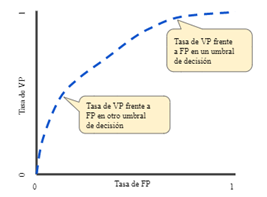


Puesto que queremos centrarnos en obtener el mejor clasificador posible, tanto para detectar casos positivos como negativos evaluaremos nuestro modelo en base a la métrica `balanced_accuracy`.

La métrica `roc_auc` la descartamos pues no consideramos que sea una métrica que nos interese para este problema. De forma intuitiva, el área bajo la curva nos indica cuan bien generaliza el modelo. Dado que nuestra muestra no está balanceada no serían resultados concluyentes.

In [ ]:
scoring = ['balanced_accuracy', 'recall_weighted']

### Vecinos más cercanos

In [ ]:
utils.evaluate_estimator(k_neighbors_model, X_train, y_train, cv, scoring)

Estos resultados son bastante prometedores, esperamos poder mejorarlos realizando la apropiada búsqueda en Grid en la siguiente sección.

---

### Árbol de decisión

In [ ]:
utils.evaluate_estimator(decision_tree_model, X_train, y_train, cv, scoring)

El árbol de decisión obtiene unos resultados bastante malos en comparación con los vecinos más cercanos. En este modelo podría estar pasando justo lo contrario y que nuestro modelo esté sesgado. Recordemos que la profundidad del árbol es 3 con post-poda y esto podría limitar el aprendizaje del mismo. También podría ocurrir que un árbol de decisión no pueda extraer más información de nuestra base de conocimientos. 

---

### Adaboost

In [ ]:
utils.evaluate_estimator(adaboost_model, X_train, y_train, cv, scoring)

Como era de esperar de un ensemble, obtiene mejores resultados que un solo árbol de decisión. Cabe destacar la diferencia en la varianza del conjunto de `train` y de `test`.

### Bagging

In [ ]:
utils.evaluate_estimator(bagging_model, X_train, y_train, cv, scoring)

Buenos resultados, siendo semejantes al Adaboost. Sin embargo, son peores que el Adaboost pero mejores que los árboles de decisión, como cabía esperar de un ensemble. 

### Random Forest

In [ ]:
utils.evaluate_estimator(random_forest_model, X_train, y_train, cv, scoring)

Teóricamente un modelo Random Forest obtendrá mejores resultados que el ensemble Bagging. Estos resultados a priori corroboran dicha afirmación.

### Gradient Boosting

In [ ]:
utils.evaluate_estimator(gradient_boosting_model, X_train, y_train, cv, scoring)

Sorprende que estos resultados se encuentren entre los peores de todos los modelos pues Gradient Boosting, teóricamente, debería obtener mejores resultados. Se espera optimizar sus hiperparámetros en la búsqueda en Grid.

### Histogram gradient boosting

In [ ]:
utils.evaluate_estimator(hist_gradient_boosting_model, X_train, y_train, cv, scoring)

## Selección de modelos

En este apartado se efectuarán las búsquedas Grid para iterar entre todas las posibles combinaciones de los hiperparámetros y así obtener el mejor modelo. Se seguirá usando la métrica `balanced_accuracy` para elegir que modelo será el mejor. Sin embargo, también se clasificará con `recall_weighted` para saber si ambas métricas difieren mucho.

### Vecinos más cercanos

* `weights`: Como se ha estudiado usar la distancia como medida de peso para los vecinos nos proporciona una mayor fiabilidad siempre y cuando las fronteras de decisión sean claras y nuestra muestra está balanceada y no tenga ruido. Es por eso que también usaremos los pesos de cada instancia de manera uniforme de esta forma se reduce la sensibilidad al ruido, aunque se aumenta los errores en muestras desbalanceadas cuando nuestra instancia a predecir está cerca de la frontera de decisión. 
* `n_neighbors`: Éste es el hiperparámetro más importante a optimizar. Muy pocos vecinos generaría un sobreajuste muy grande y dado la enorme varianza que eso supondría en caso de ruido. Por otra parte, un exceso de vecinos puede llevar al modelo a comportarse como un zero-R eligiendo siempre la clase mayoritaria del conjunto de datos. <br>Se ha elegido siempre números impares para no generar nunca casos de empate. 
* `p`:  Este hiperparámetro nos especificará cómo se eligen los vecinos más cercanos. Ya sea, por la distancia de Manhattan o la distancia euclídea. 



In [ ]:
estimator = k_neighbors_model

weights = ["uniform", "distance"]
n_neighbors = [1, 3, 5, 9, 11, 15, 19]
p = [1,2] # 1 = Distancía de Manhattan; 2 = Distancía euclidea 


k_neighbors_clf = utils.optimize_params(estimator,
                                        X_train, y_train, cv,
                                        kneighborsclassifier__weights=weights,
                                        kneighborsclassifier__n_neighbors=n_neighbors,
                                        kneighborsclassifier__p=p,
                                        scoring=scoring, refit='balanced_accuracy')

A pesar de que hemos comentado que los casos con pocos vecinos pueden derivar en sobreajuste observamos que hemos obtenido un modelo con simplemente cinco vecinos. Observamos también que tanto la métrica `balanced_acuracy` como `recall_weighted` coinciden en que el modelo seleccionado es el mejor. 

---

### Árbol de decisión

En esta búsqueda destaca con respecto a la anterior que se buscará optimizar de manera conjunta tanto los hiperparámetros de la discretización como del modelo, en este caso un árbol de decisión. 
La discretización aparecerá siempre con los mismos hiperparámetros en el resto de Grid, cuando corresponda. 

* `strategy`: Indica al discretizador qué método ha de usar para generar las particiones. Probaremos tanto con la supervisada por igual frecuencia `quantile` pues fue por la que se optó en la práctica anterior debido a las distribuciones de los datos. También se usará el método no supervisado por la k-medias `kmeans`.
* `n_bins`: Indicará en cuantas particiones se particionará la variable predictora. Se usarán únicamente números pares.

En el árbol de decisión se modificarán tres hiperparámetros:
* `max_depth`: Con el objeto de que el árbol no sobreajuste se intentará buscar la profundidad mínima que nos garantice los mejores resultados. De la práctica anterior sabemos que el árbol crece hasta una profundidad máxima de 7.
* `criterion`: Buscará qué forma de medir las particiones es mejor a este problema. Solo puede tomar dos valores: `entropy` y `gini`.
* `ccp_alpha`: Ya se está limitando el sobreajuste del árbol, ya sea por medio de la profundidad máxima y de los casos mínimos por hoja (establecida en 25). No obstante, daremos la posibilidad al árbol de una post-poda. 


In [ ]:
estimator = decision_tree_model

max_depth = [3, 5, 7]
criterion = ['entropy', 'gini']
ccp_alpha = [0.0, 0.05, 0.1]


strategy = ['kmeans','quantile']
n_bins = [2, 4, 6]

decision_tree_clf = utils.optimize_params(estimator,
                                        X_train, y_train, cv,
                                        decisiontreeclassifier__max_depth=max_depth,
                                        decisiontreeclassifier__criterion=criterion,
                                        decisiontreeclassifier__ccp_alpha=ccp_alpha,
                                        kbinsdiscretizer__strategy = strategy,
                                        kbinsdiscretizer__n_bins = n_bins,
                                        scoring=scoring, refit='balanced_accuracy')

Tras realizar la búsqueda en Grid se han obtenido unos resultados muy parecidos al caso base del que se partía. Cabe destacar las diferencias, siendo estas en `criterion` que ha pasado de `entropy` a `gini`. Y en `ccp_alpha` pasando de 0.1 a 0.0 pues no se requiere de una post-poda al estar el árbol ya restringido por la profundidad y las hojas mínimas por nodo.

---

### Adaboost

El número de iteraciones o estimadores no será controlado en esta búsqueda, dejándolo por defecto (50). Esto es debido a que se sabe que un ensemble obtendrá mejores resultados a más iteraciones o estimadores. Sin embargo, sí que se modificarán los siguientes hiperparámetros:
* `learning_rate`: Controla la contribución de los estimadores internos en la combinación final. Default = 1.0. Se probarán valores más pequeños con el objeto de intentar reducir el sobreajuste.
* ` min_samples_split`: Este hiperparámetro afecta a los 1-R que con los que se genera el ensemble. Determina el número mínimo de casos necesarios para considerar una partición. Esto se hace con el objeto de no tener particiones donde haya muy poco datos y por lo tanto, sobreajuste. Por defecto, este valor es 2.
* `criterion`: Este hiperparámetro es interno de los 1-R. Decidirá cual es la mejor métrica para generar las particiones.


In [ ]:
estimator = adaboost_model

min_samples_split = [2, 20, 50]
criterion = ['entropy', 'gini']

learning_rate = [0.3, 0.5, 1]


adaboost_clf = utils.optimize_params(estimator,
                                        X_train, y_train, cv,
                                        adaboostclassifier__base_estimator__min_samples_split=min_samples_split,
                                        adaboostclassifier__base_estimator__criterion=criterion,
                                        adaboostclassifier__learning_rate=learning_rate,
                                        scoring=scoring, refit='balanced_accuracy')

Las conclusiones que podemos sacar tras obtener los resultados de la búsqueda Grid son variadas. Primero, cabe destacar que el hiperparámetro `min_samples_split` no tiene ninguna relevancia en nuestro problema. Esto es debido a que al trabajar sobre un 1-R siempre tendremos todo el conjunto de entrenamiento que es claramente superior a los parámetros puestos. 

En cuanto al `learning_rate` podemos percatarnos que si se utiliza el `criterion` de entropía obtiene mejores resultados con 1, el valor por defecto. Mientras que si se utiliza el Gini obtendrá mejores resultados con un 0.5. Esto será cuando nos fijemos en ` mean_test_balanced_accuracy`.


### Bagging

Al igual que en Boosting, no tendremos en cuenta el número de meta-modelos dejando el valor por defecto, 10.

Como ya se explicó anteriormente, los meta-modelos no aprenden con la base de conocimientos completa, sino con una muestra extraída de forma aleatoria y con remplazo. Éstos serán los hiperparámetros que se buscarán optimizar por medio de la búsqueda Grid.
* `max_samples`: Número de instancias extraídas del conjunto completo. Default = 1.0
* `max_features`: Número de variables predictoras usadas para entrenar el meta-modelo. Default = 1.0
* `oob_score`: Instancias *Out-Of-Bag* para estimar el error. 

La búsqueda de hiperparámetros para la discretización será igual que en el árbol de decisión. 

In [ ]:
estimator = bagging_model

max_samples = [0.25, 0.5, 0.75]
max_features = [0.25, 0.5, 0.75]
oob_score = [True, False]

strategy = ['kmeans','quantile']
n_bins = [2, 4, 6]

bagging_clf = utils.optimize_params(estimator,
                                     X_train, y_train, cv,
                                     baggingclassifier__max_samples=max_samples,
                                     baggingclassifier__max_features=max_features,
                                     baggingclassifier__oob_score=oob_score,
                                     kbinsdiscretizer__strategy = strategy,
                                     kbinsdiscretizer__n_bins = n_bins,
                                     scoring=scoring, refit='balanced_accuracy')

Tras obtener los resultados de la búsqueda Grid podemos observar:

 * El hiperparámetro `oob_score` no aporta ningún tipo de información. Esto se puede deber a la validación cruzada que se realiza para validar cada modelo. 
 * La discretización tampoco parece afectarle. También podría deberse a que los hiperparámetros proporcionados no son los apropiados para el algoritmo.
 * `max_features` y `max_samples` parecen ser los hiperparámetros más importantes entre todos los que se utilizan en la búsqueda Grid. 
 
Se ha concluido que con el 75% de las variables predictoras y la mitad de las instancias es la mejor combinación para entrenar cada estimador.

---

### Random Forest

El Random Forest esta formado de árboles sin limite de profundidad, es decir, árboles con alta varianza y mucho sobreajuste. Por esto mismo no realizaremos modificaciones en el Grid con respecto a los hiperparámetros de los árboles que conforman el bosque. 

No obstante, realizaremos una búsqueda en los hiperparámetros del bosque, concretamente en las instancias y variables que se seleccionaran de forma aleatoria para entrenar cada árbol. 
* `max_samples`: Número de instancias que se seleccionarán para entrenara un árbol. Puede tomar como parámetros un `int` indicando de manera explícita el número de instancias a usar del conjunto original, `float` siendo el porcentaje en tanto por 1 de las instancias que se usarán.
* `max_features`: Número de variables que se considerarán cuando se entrene un árbol. Puede tomar como parámetros `sqrt` siendo la raíz cuadrada, `log2` siendo el logaritmo en base 2, `int` indicando de manera explicita cuantas variables se han de usar, `float` indicando en tanto por uno el porcentaje de variables a usar. 

Al igual que en todos los casos anteriores donde se aplicaba la discretización, se realizará la misma búsqueda. 

In [ ]:
estimator = random_forest_model

max_samples = [0.25, 0.5, 0.75]
max_features = ['sqrt', 'log2']

strategy = ['kmeans','quantile']
n_bins = [2, 4, 6]

random_forest_clf = utils.optimize_params(estimator,
                                               X_train, y_train, cv,
                                               randomforestclassifier__max_samples=max_samples,
                                               randomforestclassifier__max_features=max_features,
                                               kbinsdiscretizer__strategy=strategy,
                                               kbinsdiscretizer__n_bins=n_bins,
                                               scoring=scoring, refit='balanced_accuracy')


Tras realizar la búsqueda en Grid observamos que:
* Hemos obtenido los mismos resultados en los hiperparámetros de la discretización que para el modelo bagging. Esto se puede deber a que se ha configurado el bagging de forma muy similar al comportamiento de un Random Forest. Es por eso que es normal obtener los mismos resultados o por lo menos unos muy parecidos. 
  No serán igual dado que el Random Forest tiene 100 estimadores mientras que bagging simplemente se le han especificado 10 estimadores. También hay que tener en cuenta que ambos modelos usan la aleatoriedad para crear el muestreo con remplazo, por lo tanto, eso también variará.
* `max_samples` será el 50% de las instancias, al igual que en Bagging. 



---

### Gradient Boosting

Como ya se ha hecho con los modelos anteriores que usaban árboles como meta-estimador y se le realizaba una discretización se usarán los mismos parámetros en la búsqueda en Grid en el Gradient Boosting. 
También restringiremos la profundidad máxima a la que puede crecer cada árbol (meta-estimador).

Como ya se ha explicado anteriormente, Gradient Boosting usa una función de perdidad. Esto se controla en sklearn con el hiperparámetro `loss`. Este hiperparámetro puede tomar dos valores: `deviance` siendo la regresión logística y `exponential`.

Para especificar cuanto pesa cada árbol se usará el hiperparámetro `learning_rate`. Teniendo un valor por defecto de 0.1.

El hiperparámetro `subsample` controla la fracción del conjunto original de entrenamiento que será usada para entrenar cada árbol. El valor por defecto es 1.0. En el caso de que el valor de este hiperparámetro sea menor a 1 el algoritmo pasará a ser Stochastic Gradient Boosting. Además se obtendrá una reducción de la varianza y un incremento del sesgo.


In [ ]:
estimator = gradient_boosting_model

loss = ['deviance', 'exponential'] # ‘deviance’ = logistic regression
learning_rate = [0.035, 0.1]
subsample = [0.35, 1]

max_depth = [1, 3, 7]

strategy = ['kmeans','quantile']
n_bins = [2, 4, 6]

gradient_boosting_clf = utils.optimize_params(estimator,
                                               X_train, y_train, cv,
                                               gradientboostingclassifier__loss = loss,
                                               gradientboostingclassifier__learning_rate = learning_rate,
                                               gradientboostingclassifier__subsample = subsample,
                                               gradientboostingclassifier__max_depth=max_depth,
                                               kbinsdiscretizer__strategy=strategy,
                                               kbinsdiscretizer__n_bins=n_bins,
                                               scoring=scoring, refit='balanced_accuracy')

Tras realizar la búsqueda en Grid podemos observar los siguientes resultados:
* La discretización, al igual que en casos anteriores, funcionan mejor seis particiones. Podemos observar que los peores casos son con dos particiones.
  <br>A diferencia de los modelos anteriores esta discretización no usará `kmeans` si no que usará `quantile`.
* El hiperparámetro `subsample` ha resultado ser menor que uno. Como ya se ha comentado antes, esto generará una menor varianza a cambio de un mayor sesgo. 
* La profundidad de los árboles (`max_depth`) parece afectar mucho al algoritmo, siendo árboles pequeños más efectivos que grandes árboles sobreajustados.
* Se ha elegido la regresión logística (`deviance`) como función de perdida `loss`.


---

### Histogram Gradient Boosting

A pesar de el modelo Histogram Gradient Boosting está diseñado con el objeto de ser eficiente para grandes bases de datos (más de 10 000 instancias) haremos uso de el igualmente pues sigue aportando buenos resultados.

En esta búsqueda en Grid solamente se explorarán dos hiperparámetros: 
* `min_samples_leaf`: Los casos mínimos requeridos para considerar un nodo hoja. Para datasets pequeños es recomendable que sea menos de unos pocos cientos. Es recomendable establecer este valor bajo puesto solo se van a construir árboles muy profundos. 
* `learning_rate`: La tasa de aprendizaje o también conocida como *shrinkage*. Es usada como factor multiplicativo para los nodos hojas. Por defecto es 0.1. Establecer este hiperparámetro como 1 será lo mismo que establecer que no haya *shrinkage*.


In [ ]:
estimator = hist_gradient_boosting_model

min_samples_leaf = [20, 50, 70]
learning_rate = [0.05, 0.1, 0.2]

hist_gradient_boosting_clf = utils.optimize_params(estimator,
                                                  X_train, y_train, cv,
                                                  histgradientboostingclassifier__learning_rate=learning_rate,
                                                  histgradientboostingclassifier__min_samples_leaf=min_samples_leaf,
                                                  scoring=scoring, refit='balanced_accuracy')

Tras realizar la búsqueda en Grid podemos observar los siguientes resultados:
* El `learning_rate` menor que uno siempre ha generado peores resultados. 
* Aparentemente  con `min_sample_leaf` altos se obtienen mejores resultados. No obstante, como se han establecido valores pequeños en la búsqueda Grid no quiere decir que valores superiores vayan a aportar mejores resultados siempre. 


## Construcción y validación del modelo final


Una vez hemos obtenido por medio de la búsqueda en Grid todos los modelos podemos validarlos contra el conjunto de test para saber cuál ha resultado ser el mejor modelo.

In [ ]:
estimators = {
    "Nearest neighbors": k_neighbors_clf,
    "Decision tree": decision_tree_clf,
    "AdaBoost": adaboost_clf,
    "Bagging": bagging_clf,
    "Random Forests": random_forest_clf,
    "Gradient Boosting": gradient_boosting_clf,
    "Histogram Gradient Boosting": hist_gradient_boosting_clf
}

In [ ]:
utils.evaluate_estimators(estimators, X_train, y_train, X_test, y_test)

En la tabla superior podemos observar los resultados del conjunto de test contra todos los modelos. Nos fijaremos en especial sobre `M – recall` pues como ya comentábamos en la anterior práctica, siempre será mejor un falso positivo que un falso negativo, para el caso de `M`.

El modelo “ganador” sería el `Gradient Boosting` con un `M - recall` del 94,3% y un score del 95,5%. 

`Histogram Gradient Boosting` tiene una puntuación del 94,55% y un `M - recall` idéntico a los `Vecinos más cercanos`.

El siguiente modelo, ordenado por score, sería el `Random Forest` con un 94% similar a `Histogram Gradient Boosting`. Empero, `M - recall` desciende hasta un 90%.  
Posteriormente se encuentra el `Decision tree` con unas puntuaciones muy similares, descendiendo el score un 1%.

Cabe destacar los resultados del `AdaBoost` y del `Bagging`. Ambos siendo ensembles formados por árboles de decisiones deberían obtener mejores resultados que un simple árbol de decisión. En este caso no es así, incluso llegando a obtener un 4% menos de diferencia en `M - recall`. Esto pensamos que ha podido ocurrir por la partición de los datos y la semilla y no siendo un caso extrapolable a todos los casos.

Por último, observamos que los vecinos más cercanos es el peor modelo tanto en `score` como en `M – recall` con unas diferencias de un 10%.

<br>

Para una mayor legibilidad de los resultados se han representado todos los modelos en una matriz de confusión clasificando el conjunto de test. **Advertencia**: La puntuación junto a las matrices de confusión es la `accuracy` siendo completamente diferente del score de la tabla superior. Dicho score hace referencia a la métrica `balanced_accuracy`.


In [ ]:
print('k_neighbors_clf')
utils.evaluate(k_neighbors_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('decision_tree_clf')
utils.evaluate(decision_tree_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('adaboost_clf')
utils.evaluate(adaboost_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('bagging_clf')
utils.evaluate(bagging_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('random_forest_clf')
utils.evaluate(random_forest_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('gradient_boosting_clf')
utils.evaluate(gradient_boosting_clf.best_estimator_, X_train, X_test, y_train, y_test)

In [ ]:
print('hist_gradient_boosting_clf')
utils.evaluate(hist_gradient_boosting_clf.best_estimator_, X_train, X_test, y_train, y_test)

---
---

# Logistic Regression Project (Predict Ad click)

---

### **Cambios**

* Se ha encontrado una importante fuga de datos. Se ha ido indicando donde se encontraba mediante `fuga de datos`.
* Se ha remplazado todo el preprocesamiento por un pipeline de sklearn.
* Con el objeto de mantener un idioma común en toda la libreta se ha traducido completamente la libreta original del inglés al español.
* Para mantener una libreta más limpia se han movido las declaraciones de los métodos al script de `utils`.

---

La Regresión Logística se utiliza comúnmente para estimar la probabilidad de que una instancia pertenezca a una clase particular. Si la probabilidad estimada de que una instancia sea mayor del 50%, entonces el modelo predice que la instancia pertenece a esa clase 1, o bien predice que no es así. Esto lo convierte en un clasificador binario. En esta libreta veremos la teoría detrás de la Regresión Logística y la usaremos para indicar si un usuario particular de Internet hizo clic o no en un anuncio. Intentaremos crear un modelo que prediga si harán clic o no en un anuncio basado en las características de ese usuario.

Este conjunto de datos contiene las siguientes características:

* '`Daily Time Spent on Site`': tiempo del consumidor en el sitio en minutos
* '`Age`': edad del consumidor en años
* '`Area Income`': Promedio de ingresos de la zona geográfica del consumidor
* '`Daily Internet Usage`': La media de minutos al día que el consumidor está en Internet
* '`Ad Topic Line`': Cabecera del anuncio
* '`City`': Ciudad del consumidor
* '`Male`': Si el consumidor era hombre o no
* '`Country`': Pais del consumidor
* '`Timestamp`': Hora en la que el consumidor pulsó en el anuncio o cerró la ventana
* '`Clicked on Ad`': 0 o 1 indicando si se hizo click en el anuncio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# Scripts
import miner_a_de_datos_aprendizaje_modelos_utilidad as utils

In [ ]:
# Variación: No se había declarado una semilla
seed = 337839890

### Obtener los datos

*En la libreta original no se dividia el conjunto hasta mucho más adelante. Nos hallamos ante una fuga de datos debido a que vamos a visualizar información de todos los datos.*

In [ ]:
data = pd.read_csv("../input/advertising/advertising.csv")

# ERROR: Mostrar el head no es una muestra siginificativa del conjunto
# data.head()

In [ ]:
# NUEVO
train, test, X_train, X_test, y_train, y_test = utils.split_data(data, 'Clicked on Ad', seed=seed, train_size=0.7)

In [ ]:
# NUEVO
print(train.shape)
train.sample(5, random_state=seed)

In [ ]:
# NUEVO
print(test.shape)
test.sample(5, random_state=seed)

In [ ]:
# Fuga de datos: data.info()

train.info()

In [ ]:
# Fuga de datos: data.describe()
train.describe()

## 1. Análisis exploratorio de los datos

*En la libreta original no se ha explicado nada de ninguna gráfica. Sería recomendable explicar qué representa cada una.*

In [ ]:
# Fuga de datos: data.Age.hist(bins=data.Age.nunique())
plt.figure(figsize=(10, 8))
train.Age.hist(bins=train.Age.nunique())
plt.xlabel('Age')

La distribución de las edades sigue una distribución normal con tendencia a la derecha. 

In [ ]:
# Fuga de datos: sns.jointplot(data["Area Income"], data.Age)
sns.jointplot(train["Area Income"], train.Age)

En la gráfica superior se puede observar la correlación entre las variables `Area Income` y `Age`. Podemos observar una mayor concentración de altos ingresos en edades alrededor de los 30 años.

In [ ]:
# Fuga de datos: sns.jointplot(data["Daily Time Spent on Site"], data.Age, kind='kde')
sns.jointplot(train["Daily Time Spent on Site"], train.Age, kind='kde')

En la gráfica superior se puede observar la correlación entre las variables `Daily Time Spent on Site ` y `Age`. Podemos observar que alrededor de los 30 años se tiende a pasar más tiempo en una página web.

In [ ]:
# Fuga de datos: sns.jointplot(data["Daily Time Spent on Site"], data["Daily Internet Usage"])
sns.jointplot(train["Daily Time Spent on Site"], train["Daily Internet Usage"])

En la gráfica superior se puede observar la correlación entre las variables `Daily Time Spent on Site ` y `Daily Internet Usage`. Podemos observar que existen dos partes diferenciadas. Por una parte, tendremos las personas que dedican poco tiempo a internet y por lo tanto dedican poco tiempo en cada página web. Por otra parte, observamos el opuesto, gente que pasa mucho tiempo en internet y dedica más tiempo a cada página web.

In [ ]:
# Fuga de datos: sns.pairplot(data, hue='Clicked on Ad')
sns.pairplot(train, hue='Clicked on Ad')

En la gráfica superior se puede observar la correlación entre todas las variables representables. Dichas gráficas diferenencian por la variable `Clicked on Ad` que es nuestra variable objetivo. Podemos observar que hay una clara diferenciación entre los valores de la variable clase. En especial para `Daily Internet Usage`.

In [ ]:
# Fuga de datos: data['Clicked on Ad'].value_counts()
train['Clicked on Ad'].value_counts()

In [ ]:
# Fuga de datos: sns.heatmap(data.corr(), annot=True)
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True)

El mapa de calor superior nos muestra que no existe una gran correlación entre variables. Las únicas excepciones serían las variables: `Clicked on Ad` con `Daily Time Spent on Site` y con `Dailiy Internet Usage`. Ambas muestran una correlación inversa.

## 2. Teoría de Regresión Logistica

*En este apartado no se han realizado modificaciones por errores si no por estética*

La regresión logística es el algoritmo de clasificación lineal para problemas de dos clases. Es fácil de implementar, fácil de entender y obtiene grandes resultados en una amplia variedad de problemas, incluso cuando se incumplen las expectativas que el método tiene para sus datos.

### Descripción

#### Regresión logística

La regresión logística se denomina así por la función utilizada en el núcleo del método, la [función logística](https://en.wikipedia.org/wiki/Logistic_function).

La función logística, también llamada la **`función sigmoide`** fue desarrollada por los estadísticos para describir las propiedades del crecimiento de la población en la ecología, aumentando rápidamente y maximizando la capacidad de carga del medio ambiente. Es una curva en forma de S que puede tomar cualquier número de valor 

$$\frac{1}{1 + e^{-x}}$$

$e$ es la base del logaritmo natural y $x$ es el valor que quieres transformar por medio de la función logística.

In [ ]:
x = np.linspace(-6, 6, num=1000)
plt.figure(figsize=(10, 6))
plt.plot(x, (1 / (1 + np.exp(-x))))
plt.title("Sigmoid Function")

La ecuación de regresión logística tiene una representación muy similar a la de la regresión lineal. La diferencia es que el valor de salida que se modela es de naturaleza binaria.

$$\hat{y}=\frac{e^{\beta_0+\beta_1x_1}}{1+\beta_0+\beta_1x_1}$$

o

$$\hat{y}=\frac{1.0}{1.0+e^{-\beta_0-\beta_1x_1}}$$

$\beta_0$ es el término de intercepción

$\beta_1$ es el coeficiente para $x_1$

$\hat{y}$ es la salida prevista con un valor real entre 0 y 1. Para convertirla en una salida binaria de 0 o 1, sería necesario redondearla a un valor entero o proporcionar un punto de corte para especificar el punto de segregación de la clase.
***
### Aprendiendo el modelo de regresión logística

Los coeficientes (valores Beta b) del algoritmo de regresión logística deben ser estimados a partir de los datos de entrenamiento. Esto se hace usando la [estimación de máxima probabilidad](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

La estimación de máxima probabilidad es un algoritmo de aprendizaje común utilizado por una variedad de algoritmos de Machine Learning, aunque hace suposiciones sobre la distribución de sus datos (más sobre esto cuando hablamos de la preparación de sus datos).

Los mejores coeficientes darían como resultado un modelo que predeciría un valor muy cercano a 1 (por ejemplo, masculino) para la clase por defecto y un valor muy cercano a 0 (por ejemplo, femenino) para la otra clase. La intuición de la máxima probabilidad para la regresión logística es que un procedimiento de búsqueda busca valores para los coeficientes (valores Beta) que minimicen el error en las probabilidades predichas por el modelo a las de los datos (por ejemplo, probabilidad de 1 si los datos son de la clase primaria).

No vamos a entrar en la matemática de la máxima probabilidad. Basta decir que se utiliza un algoritmo de minimización para optimizar los mejores valores de los coeficientes de sus datos de entrenamiento. Esto se implementa a menudo en la práctica utilizando un algoritmo de optimización numérica eficiente (como el método Quasi-newton).

Cuando se está aprendiendo logística, se puede implementar desde cero utilizando el algoritmo de gradiente descendiente mucho más sencillo.

In [ ]:
# Se ha trasladado al utils la función 'print_score'.

Razones para utilizar `scikit-learn` (no Pandas) para el preprocesamiento de ML:
1. Puedes hacer validación cruzada de todo el flujo de trabajo.
2. Puedes cuadricular el modelo de búsqueda y los hiperparámetros de preprocesamiento.
3. Evita añadir nuevas columnas al DataFrame de origen.
4. Pandas carece de pasos de ajuste/transformación separados para evitar la fuga de datos.

*Fuga de Datos: La separación entre conjuntos de test y train no se había realizado hasta este apartado.*

*Se va a construir un Pipeline para el preprocesamiento de los datos.*

In [ ]:
to_drop_columns_names = ['Timestamp', 'Ad Topic Line', 'Country', 'City']
to_drop_columns = [X_train.columns.get_loc(column) for column in to_drop_columns_names]
drop_transformer = utils.drop_columns(to_drop_columns)

In [ ]:
num_columns = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male']

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

## 3. Preparación de los datos para la regresión logística

Las suposiciones hechas por la regresión logística sobre la distribución y las relaciones en sus datos son muy parecidas a las suposiciones hechas en la regresión lineal.

Se han realizado muchos estudios para definir estas suposiciones y se utiliza un lenguaje probabilístico y estadístico preciso. Mi consejo es usarlos como pautas o reglas generales y experimentar con diferentes esquemas de preparación de datos.

En última instancia, en los proyectos Machine Learning de modelado predictivo, el objetivo se centra en hacer predicciones precisas en lugar de interpretar los resultados. Como tal, puedes romper algunas suposiciones siempre y cuando el modelo sea robusto y tenga un buen rendimiento.

- **Variable de salida binaria:** Esto podría ser obvio como ya lo hemos mencionado, pero la regresión logística está pensada para problemas de clasificación binaria (de dos clases). Predecirá la probabilidad de que una instancia pertenezca a la clase por defecto, que puede ser encajada en una clasificación de 0 o 1.
- **Eliminar el ruido:** La regresión logística no supone ningún error en la variable de salida (y), hay que considerar la posibilidad de eliminar los valores atípicos y las posibles instancias mal clasificadas de sus datos de entrenamiento.
- **Distribución Gaussiana:** La regresión logística es un algoritmo lineal (con una transformación no lineal en la salida). Supone una relación lineal entre las variables de entrada y las de salida. Las transformaciones de datos de sus variables de entrada que exponen mejor esta relación lineal pueden dar lugar a un modelo más preciso. Por ejemplo, puede usar log, root, Box-Cox y otras transformaciones univariantes para exponer mejor esta relación.
- **Eliminar entradas correlacionadas:** Como la regresión lineal, el modelo puede sobreajustarse si se tienen múltiples entradas altamente correlacionadas. Considera el cálculo de las correlaciones por pares entre todas las entradas y elimina las entradas altamente correlacionadas.
- **Fallar en la convergencia:** Es posible que el proceso de estimación de la verosimilitud esperada que aprende los coeficientes no converja. Esto puede suceder si hay muchas entradas altamente correlacionadas en sus datos o si los datos son muy escasos (por ejemplo, muchos ceros en sus datos de entrada).

*Se ha añadido un Pipeline*

In [ ]:
lr_clf = make_pipeline(
    drop_transformer,
    ct,
    LogisticRegression(solver='liblinear')
)

In [ ]:
rf_clf = make_pipeline(
    drop_transformer,
    ct,
    RandomForestClassifier(n_estimators=1000)
)

## 4. Implementación de la regresión logística en Scikit-Learn

*No explicaban nada de los resultados obtenidos.*

In [ ]:
# lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

utils.print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
utils.print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Podemos observar que hemos obtenido una mayor accuracy con el conjunto de test que con el conjunto de entrenamiento. Esto es debido a la varianza que presentan los datos. 

Hemos obtenido una accuracy muy alta, por lo que se espera obtener unas buenas predicciones reales. 

In [ ]:
# rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf.fit(X_train, y_train)

utils.print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
utils.print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Podemos observar que los resultados del conjunto de entrenamiento (train) es de un 100%. Mientras que en el conjunto de prueba (test) se ha obtenido un 97.67%. Por lo tanto, observamos un sobreajuste de los datos. 

## 5. Medida del rendimiento

#### 1. Matriz de la confusión

- Cada fila: clase real

- Cada columna: clase prevista

Primera fila: Anuncios sin clic, la clase negativa:

* 146 fueron clasificados correctamente como anuncios no seleccionados. **Verdaderos negativos**.

* Los 4 restantes fueron erróneamente clasificados como anuncios en los que se ha hecho clic. **Falsos positivos**.

Segunda fila: Los anuncios clicados, la clase positiva:

* 4 se clasificaron incorrectamente como Anuncios sin clic. **Falsos negativos**

* 143 se clasificaron correctamente en los anuncios de clic. **Verdaderos positivos**.

### 2. Precisión

La *precisión* mide la exactitud de las predicciones positivas. También llamada la precisión del clasificador ==> `97.33%`

$$\textrm{precision} = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Positives}}$$

#### 3. Recall

"Precisión" se usa típicamente con "recall" ("Sensibilidad" o "Tasa positiva real"). La proporción de instancias positivas que son detectadas correctamente por el clasificador.

$$\textrm{recall} = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Negatives}}$$ ==> `97.33%`

#### 4. F1 Score

$F_1$ score es el medio armónico de la precisión y el recall. La media regular da el mismo peso a todos los valores. La media armónica da más peso a los valores bajos.


$$F_1=\frac{2}{\frac{1}{\textrm{precision}}+\frac{1}{\textrm{recall}}}=2\times \frac{\textrm{precision}\times \textrm{recall}}{\textrm{precision}+ \textrm{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$$ ==> `97.33%`

El $F_1$ favorece a los clasificadores que tienen una precisión y un recall similares.

#### 5. Precisión / Recall Tradeoff

El aumento de la precisión reduce el recall y viceversa.

In [ ]:
# Se ha trasladado al utils la función 'plot_precision_recall_vs_threshold'.
utils.plot_precision_recall_vs_threshold(lr_clf, X_test, y_test)

Con este gráfico, puede seleccionar el valor de umbral que le da la mejor precisión/recall para su tarea.

Algunas tareas pueden requerir una mayor precisión (exactitud de las predicciones positivas). Como diseñar un clasificador que recoja contenidos para adultos para proteger a los niños. Esto requerirá que el clasificador establezca una barra alta para permitir que cualquier contenido sea consumido por los niños.

Algunas tareas pueden requerir un mayor recall (proporción de instancias positivas que son detectadas correctamente por el clasificador). Como la detección de ladrones/intrusos en las imágenes de vigilancia - Cualquier cosa que remotamente se parezca a las instancias "positivas" debe ser recogida.

***

### La curva ROC

En lugar de trazar la precisión frente al recall, la curva ROC traza la `tasa positiva verdadera` (otro nombre para el recall) contra la `tasa positiva falsa`. La `tasa positiva falsa` (FPR) es la proporción de instancias negativas que se clasifican incorrectamente como positivas. Es igual a uno menos la `tasa negativa verdadera`, que es la proporción de instancias negativas que se clasifican correctamente como negativas.

El TNR también se llama `especificidad`. Por lo tanto, la curva ROC traza la `sensibilidad` (recall) frente a `1 - especificidad`.

In [ ]:
# Se ha trasladado al utils la función 'plot_roc_curve'.
utils.plot_roc_curve(lr_clf, X_test, y_test)

In [ ]:
roc_auc_score(y_test, lr_clf.predict(X_test))

Usa la curva PR cuando la clase **positiva es rara** o cuando te preocupas más por los falsos positivos que por los falsos negativos

Usa la curva ROC cuando la clase **negativa es rara** o cuando te importan más los falsos negativos que los falsos positivos


En el ejemplo anterior, la curva ROC parecía sugerir que el clasificador es bueno. Sin embargo, cuando se mira la curva PR, se puede ver que hay espacio para mejorar.

## 6. Logistic Regression Hyperparameter tuning

In [ ]:
penalty = ['l1', 'l2']
C = [0.5, 0.6, 0.7, 0.8]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

lr_cv = utils.optimize_params(estimator=lr_clf, X=X_train, y=y_train, cv=10,
                        logisticregression__penalty=penalty, logisticregression__C=C, logisticregression__class_weight=class_weight, logisticregression__solver=solver,
                        scoring='accuracy')

utils.print_score(lr_cv.best_estimator_, X_train, y_train, X_test, y_test, train=True)
utils.print_score(lr_cv.best_estimator_, X_train, y_train, X_test, y_test, train=False)

Una vez obtenido el mejor modelo por la búsqueda en Grid observamos que el accuracy entre el conjunto entrenamiento y el conjunto de test apenas varía. 

## 7. Resumen
En esta libreta se ha descubierto el algoritmo de regresión logística para Machine Learning y el modelado predictivo. Se ha cubierto mucho terreno y se aprendió:

- Qué es la función logística y cómo se utiliza en la regresión logística.
- Que la representación clave en la regresión logística son los coeficientes, al igual que la regresión lineal.
- Que los coeficientes en la regresión logística se estiman usando un proceso llamado estimación de máxima probabilidad.
- Que hacer predicciones usando la regresión logística es tan fácil que se puede hacer en Excel.
- Que la preparación de los datos para la regresión logística es muy similar a la regresión lineal.
- Cómo evaluar un problema de clasificación de aprendizaje de una máquina.
- Cómo ajustar los hiperparámetros de la regresión logística.

### Referencias:
- [Scikit Learn Library](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
- [Logistic Regression for Machine Learning by Jason Brownlee PhD](https://machinelearningmastery.com/logistic-regression-for-machine-learning/)